# Precisa conferir as contas, não estão batendo (Fluxo de caixa)

## Importando as bibliotecas necessárias

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

## Lendo a planilha com os dados limpos

In [7]:
dfs_file = pd.ExcelFile("DFs-MRV-Limpo.xlsx", engine="openpyxl")
cotacao_file = pd.ExcelFile("Cotacoes-MRV.xlsx", engine="openpyxl")

BP = pd.read_excel(dfs_file, "BP")
DFC = pd.read_excel(dfs_file, "DFC")
DRE = pd.read_excel(dfs_file, "DRE")
COTACOES = pd.read_excel(cotacao_file, "MRVE3")

In [8]:
COTACOES.dropna(how='all', axis='columns', inplace=True)
COTACOES.drop(COTACOES.index[COTACOES['Fechamento'] == '-'], inplace = True)
BP.dropna(how='all', axis='columns', inplace=True);
DFC.dropna(how='all', axis='columns', inplace=True);
DRE.dropna(how='all', axis='columns', inplace=True); # ; supress output

## Função para encontrar células nos DataFrames com base em DF, nome da conta e ano

In [9]:
def getValue(df, nome_coluna_principal, ano, coluna_principal="MRV ON (R$ em milhares)"):
    return df[df[coluna_principal] == nome_coluna_principal][ano].values[0]

## Indicadores de Solvência de Curto Prazo

$Liquidez \; Corrente = \frac{Ativo \; Circulante}{Passivo \; Circulante}$

$Liquidez \; Seca = \frac{Ativo \; Circulante \; - \; Estoque}{Passivo \; Circulante}$

$Liquidez \; Imediata = \frac{Caixa}{Passivo \; Circulante}$

In [10]:
years = [2016, 2017, 2018, 2019, 2020]

liquidezCorrente = []
liquidezSeca = []
liquidezImediata = []

for i in years:
    ativoCirculante = getValue(BP, 'Ativo Circulante', i)
    passivoCirculante = getValue(BP, 'Passivo Circulante', i)
    estoquesCP = getValue(BP, 'Estoques CP', i)
    caixa = getValue(BP, 'Caixa e Equivalentes', i)
    
    liquidezCorrente_ = ativoCirculante / passivoCirculante
    liquidezSeca_ = (ativoCirculante - estoquesCP) / passivoCirculante
    liquidezImediata_ = caixa / passivoCirculante
    
    liquidezCorrente.append(liquidezCorrente_)
    liquidezSeca.append(liquidezSeca_)
    liquidezImediata.append(liquidezImediata_)

solvenciaCP = pd.DataFrame()   

solvenciaCP["Ano"] = years
solvenciaCP["Liquidez Corrente"] = liquidezCorrente
solvenciaCP["Liquidez Seca"] = liquidezSeca
solvenciaCP["Liquidez Imediata"] = liquidezImediata
    
solvenciaCP

,Ano,Liquidez Corrente,Liquidez Seca,Liquidez Imediata
0,2016,2.434750,1.382645,0.603056
1,2017,2.558647,1.516866,0.219424
2,2018,2.976337,1.555685,0.300937
3,2019,2.780056,1.368943,0.240517
4,2020,2.368514,1.333814,0.298883


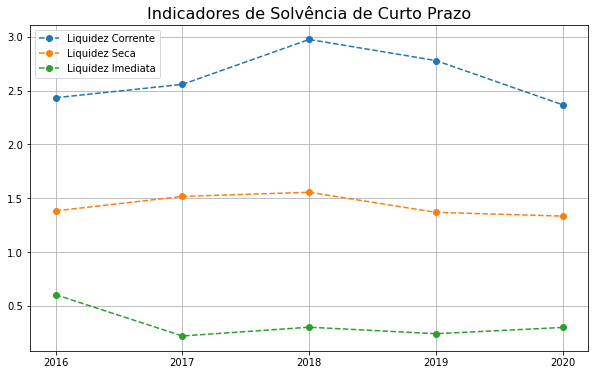

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(years, liquidezCorrente, 'o--', label="Liquidez Corrente")
plt.plot(years, liquidezSeca, 'o--', label="Liquidez Seca")
plt.plot(years, liquidezImediata, 'o--', label="Liquidez Imediata")
plt.xticks(years)
plt.title("Indicadores de Solvência de Curto Prazo", size=16)
plt.grid(True)
plt.legend()
plt.show()

## Indicadores de Solvência de Longo Prazo

$Endividamento \; Total = \frac{Passivo \; Total}{Ativo \; Total}$

$Índice \; Dívida/Capital \; Próprio = \frac{Passivo \; Financeiro}{Patrimônio \; Líquido}$

$Multiplicador \; do \; PL = \frac{Ativo \; Total}{Patrimônio \; Líquido}$

$Índice \; de \; Cobertura \; de \; Juros = \frac{LAJIR}{Juros}$

$Índice \; de \; Cobertura \; de \; Caixa = \frac{LAJIDA}{Juros}$

$Índice \; de \; Endividamento/LAJIDA = \frac{Passivo \; Total}{LAJIDA}$

In [12]:
# TODO: Confirmar se a equação de Endividamento/LAJIDA está certa
years = [2017, 2018, 2019, 2020]

endividamentoTotal = []
dividaPorCapitalProprio = []
multPatrimonioLiq = []
coberturaJuros = []
coberturaCaixa = []
endividamentoLAJIDA = []

for i in years:
    ativoTotal = getValue(BP, 'Ativo Total', i)
    passivoTotal = getValue(BP, 'Passivo Total', i)
    patrimonioLiquido = getValue(BP, 'Patrimônio Líquido Consolidado', i)
    financiamentoCP = getValue(BP, 'Financiamento CP', i)
    financiamentoLP = getValue(BP, 'Financiamento LP', i)
    debenturesCP = getValue(BP, 'Debêntures CP', i)
    debenturesLP = getValue(BP, 'Debêntures LP', i)
    dividaTotal = financiamentoCP + financiamentoLP + debenturesCP + debenturesLP
    lajir = getValue(DRE, '(=) LAJIR', i)
    lajida = lajir + getValue(DFC, 'Depreciação, Amortização e Exaustão', i)
    juros = getValue(DRE, '(-) Despesas Financeiras', i)
    
    endividamentoTotal_ = passivoTotal / ativoTotal
    dividaPorCapitalProprio_ = dividaTotal / patrimonioLiquido
    multPatrimonioLiq_ = ativoTotal / patrimonioLiquido
    coberturaJuros_ = lajir / juros
    coberturaCaixa_ = lajida / juros
    endividamentoLajida_ = passivoTotal / lajida
    
    endividamentoTotal.append(endividamentoTotal_)
    dividaPorCapitalProprio.append(dividaPorCapitalProprio_)
    multPatrimonioLiq.append(multPatrimonioLiq_)
    coberturaJuros.append(coberturaJuros_)
    coberturaCaixa.append(coberturaCaixa_)
    endividamentoLAJIDA.append(endividamentoLajida_)

solvenciaLP = pd.DataFrame()

solvenciaLP["Ano"] = years
solvenciaLP["Endividamento Total"] = endividamentoTotal
solvenciaLP["Dívida/Capital Próprio"] = dividaPorCapitalProprio
solvenciaLP["Multiplicador do PL"] = multPatrimonioLiq
solvenciaLP["Cobertura de Juros"] = coberturaJuros
solvenciaLP["Cobertura de Caixa"] = coberturaCaixa
solvenciaLP["Endividamento LAJIDA"] = endividamentoLAJIDA

solvenciaLP

,Ano,Endividamento Total,Dívida/Capital Próprio,Multiplicador do PL,Cobertura de Juros,Cobertura de Caixa,Endividamento LAJIDA
0,2017,0.601805,0.598977,2.511333,4.617404,4.958150,12.241709
1,2018,0.642544,0.587336,2.797549,7.209772,7.828535,10.876596
2,2019,0.652140,0.626794,2.874717,12.744128,14.243862,11.569320
3,2020,0.665896,0.770812,2.993083,6.576445,7.587520,14.605861


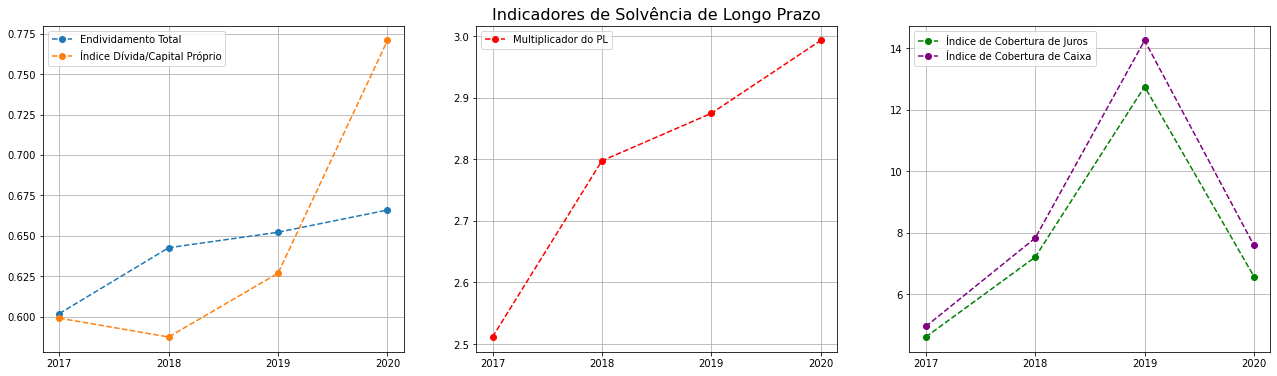

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
ax1.plot(years, endividamentoTotal, 'o--', label="Endividamento Total")
ax1.plot(years, dividaPorCapitalProprio, 'o--', label="Índice Dívida/Capital Próprio")
ax1.set_xticks(years)
ax1.grid(True)
ax1.legend()
ax2.plot(years, multPatrimonioLiq, 'o--', label="Multiplicador do PL", color="red")
ax2.set_title("Indicadores de Solvência de Longo Prazo", size=16)
ax2.set_xticks(years)
ax2.grid(True)
ax2.legend()
ax3.plot(years, coberturaJuros, 'o--', label="Índice de Cobertura de Juros", color="green")
ax3.plot(years, coberturaCaixa, 'o--', label="Índice de Cobertura de Caixa", color="purple")
ax3.set_xticks(years)
ax3.grid(True)
ax3.legend()
plt.show()

## Indicadores de Gestão de Ativos ou de Giro

$Giro \; do \; Estoque = \frac{Custo \; dos \; Produtos \; Vendidos}{Estoque}$

$Prazo \; Médio \; de \; Estocagem \; (PME) = \frac{365 \; dias}{Giro \; do \; Estoque}$

$Giro \; de \; Contas \; a \; Receber = \frac{Vendas}{Contas \; a \; Receber}$

$Prazo \; Médio \; de \; Recebimento \; (PMR) = \frac{365 \; dias}{Giro \; de \; Contas \; a \; Receber}$

$Giro \; do \; Ativo \; Total = \frac{Vendas}{Ativo \; Total}$


In [14]:
years = [2017, 2018, 2019, 2020]

giroEstoque = []
PME = []
giroContasAReceber = []
PMR = []
giroAtivoTotal = []

for i in years:
    CMV = getValue(DRE, '(-) Custo dos Produtos Vendidos', i)
    estoque = getValue(BP, 'Estoques CP', i)
    
    giroEstoque_ = CMV / estoque
    PME_ = 365 / giroEstoque_
    
    vendas = getValue(DRE, '(+) Receita Líquida Operacional', i)
    contasAReceber = getValue(BP, 'Contas a Receber CP', i)
    giroContasAReceber_ = vendas / contasAReceber
    
    PMR_ = 365/giroContasAReceber_
    
    ativoTotal = getValue(BP, 'Ativo Total', i)
    giroAtivoTotal_ = vendas / ativoTotal
    
    giroEstoque.append(giroEstoque_)
    PME.append(PME_)
    giroContasAReceber.append(giroContasAReceber_)
    PMR.append(PMR_)
    giroAtivoTotal.append(giroAtivoTotal_)

gestaoAtivos = pd.DataFrame()

gestaoAtivos["Ano"] = years
gestaoAtivos["Giro do Estoque"] = giroEstoque
gestaoAtivos["PME"] = PME
gestaoAtivos["Giro de Contas a Receber"] = giroContasAReceber
gestaoAtivos["PMR"] = PMR
gestaoAtivos["Giro do Ativo Total"] = giroAtivoTotal
    
gestaoAtivos 

,Ano,Giro do Estoque,PME,Giro de Contas a Receber,PMR,Giro do Ativo Total
0,2017,0.929700,392.599586,2.986034,122.235702,0.326949
1,2018,0.964872,378.288641,3.717675,98.179635,0.397378
2,2019,1.064072,343.021802,3.890784,93.811416,0.412338
3,2020,1.275506,286.161035,3.604664,101.257701,0.367974


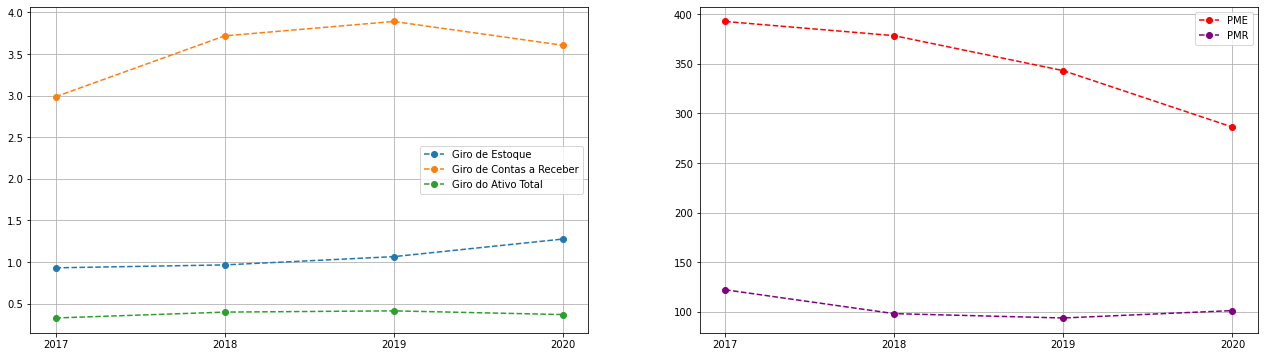

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
ax1.plot(years, giroEstoque, 'o--', label="Giro de Estoque")
ax1.plot(years, giroContasAReceber, 'o--', label="Giro de Contas a Receber")
ax1.plot(years, giroAtivoTotal, 'o--', label="Giro do Ativo Total")
ax1.set_xticks(years)
ax1.grid(True)
ax1.legend()
ax2.plot(years, PME, 'o--', label="PME", color="red")
ax2.plot(years, PMR, 'o--', label="PMR", color="purple")
ax2.set_xticks(years)
ax2.grid(True)
ax2.legend()
plt.show()

## Medidas de Lucratividade

$Margem \; Bruta = \frac{Lucro \; Bruto}{Vendas}$

$Margem \; LAJIDA = \frac{LAJIDA}{Vendas}$

$Margem \; Líquida = \frac{Lucro \; Líquido}{Vendas}$

$Retorno \; sobre \; o \; Ativo \; (ROA) = \frac{Lucro \; Líquido}{Ativo \; Total}$

$Retorno \; sobre \; o \; PL \; (ROE) = \frac{Lucro \; Líquido}{Patrimônio \; Líquido}$

In [16]:
years = [2017, 2018, 2019, 2020]

margemBruta = []
margemLAJIDA = []
margemLiquida = []
ROA = []
ROE = []

for i in years:
    
    vendas = getValue(DRE, '(+) Receita Líquida Operacional', i)
    lucroBruto = getValue(DRE, '(=) Lucro Bruto', i)
    
    margemBruta_ = lucroBruto / vendas
    
    lajir = getValue(DRE, '(=) LAJIR', i)
    lajida = getValue(DFC, 'Depreciação, Amortização e Exaustão', i) + lajir
    
    margemLAJIDA_ = lajida / vendas
    
    lucroLiquido = getValue(DRE, '(=) Lucro Líquido', i)
    
    margemLiquida_ = lucroLiquido / vendas
    
    ativoTotal = getValue(BP, 'Ativo Total', i)
    ROA_ = lucroLiquido / ativoTotal
    
    patrimonioLiquido = getValue(BP, 'Patrimônio Líquido Consolidado', i)
    ROE_ = lucroLiquido / patrimonioLiquido
    
    margemBruta.append(margemBruta_)
    margemLAJIDA.append(margemLAJIDA_)
    margemLiquida.append(margemLiquida_)
    ROA.append(ROA_)
    ROE.append(ROE_)

lucratividade = pd.DataFrame()

lucratividade["Ano"] = years
lucratividade["Margem Bruta"] = margemBruta
lucratividade["Margem LAJIDA"] = margemLAJIDA
lucratividade["Margem Líquida"] = margemLiquida
lucratividade["ROA"] = ROA
lucratividade["ROE"] = ROE

lucratividade

,Ano,Margem Bruta,Margem LAJIDA,Margem Líquida,ROA,ROE
0,2017,0.338693,0.150360,0.147067,0.048084,0.120754
1,2018,0.331889,0.148664,0.139904,0.055595,0.155528
2,2019,0.304219,0.136704,0.123499,0.050923,0.146390
3,2020,0.282010,0.123897,0.093433,0.034381,0.102906


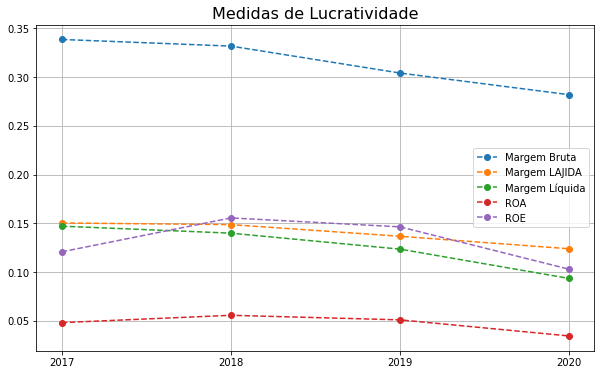

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(years, margemBruta, 'o--', label="Margem Bruta")
plt.plot(years, margemLAJIDA, 'o--', label="Margem LAJIDA")
plt.plot(years, margemLiquida, 'o--', label="Margem Líquida")
plt.plot(years, ROA, 'o--', label="ROA")
plt.plot(years, ROE, 'o--', label="ROE")
plt.xticks(years)
plt.title("Medidas de Lucratividade", size=16)
plt.grid(True)
plt.legend()
plt.show()

## Medidas de Valor de Mercado

$Índice \; Preço/Lucro = \frac{Preço \; por \; Ação}{Lucro \; por \; Ação}$

$Índice \; Valor \; de \; Mercado/Valor \; Contábil = \frac{Valor \; de \; Mercado \; por \; Ação}{Valor \; Contábil \; por \; Ação}$

In [18]:
def getYearPrice(df, year):
    df = df[df["Data"] < f"{year+1}-12-30"].tail(1)
    return float(df["Fechamento"])

#COTACOES[COTACOES["Data"] == "2010-12-30"]

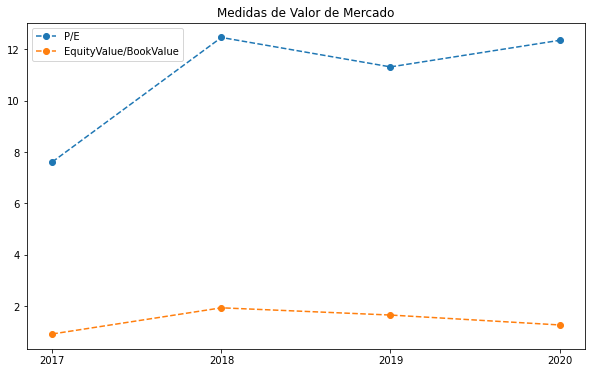

In [19]:
years = [2017, 2018, 2019, 2020]
acoes = [472989.1892, 443354.9708, 445164.2857, 445164.2857]

precoLucro = []
mercadoContabil = []

n_acoes = 4441.4 #Em milhares

for i, a in zip(years, acoes):
    
    precoPorAcao = getYearPrice(COTACOES, i)
    
    lucroLiquido = getValue(DRE, '(=) Lucro Líquido', i)
    
    lucroPorAcao = lucroLiquido/a
    precoLucro_ = precoPorAcao/lucroPorAcao
    
    valorMercado = precoPorAcao*a
    
    ativoTotal = getValue(BP, 'Ativo Total', i)
    passivoTotal = getValue(BP, 'Passivo Total', i)
    bookValue = ativoTotal - passivoTotal
        
    mercadoContabil_ = valorMercado/bookValue
    
    precoLucro.append(precoLucro_)
    mercadoContabil.append(mercadoContabil_)
    
# for i in range(len(years)):
#     print(years[i])
#     print(f"\t Índice preço/lucro:                     {precoLucro[i]}")
#     print(f"\t Índice Valor de Mercado/Valor Contábil: {mercadoContabil[i]}")

#plotar graficos
plt.figure(figsize=(10, 6))
plt.plot(years, precoLucro, 'o--', label="P/E")
plt.plot(years, mercadoContabil, 'o--', label="EquityValue/BookValue")
plt.xticks(years)
plt.title("Medidas de Valor de Mercado")
plt.legend()
plt.show()

## DuPont

$ROE = Margem \; Líquida \; \cdot \; Giro \; do \; Ativo \; \cdot Multiplicador \; do \; PL$

In [20]:
duPont = pd.DataFrame()

duPont["Anos"] = years
duPont["Margem Líquida"] = margemLiquida
duPont["Giro do Ativo"] = giroAtivoTotal
duPont["Multiplicador do PL"] = multPatrimonioLiq
duPont["ROE"] = ROE
duPont["ROE DuPont"] = duPont["Margem Líquida"] * duPont["Giro do Ativo"] * duPont["Multiplicador do PL"]

duPont

,Anos,Margem Líquida,Giro do Ativo,Multiplicador do PL,ROE,ROE DuPont
0,2017,0.147067,0.326949,2.511333,0.120754,0.120754
1,2018,0.139904,0.397378,2.797549,0.155528,0.155528
2,2019,0.123499,0.412338,2.874717,0.146390,0.146390
3,2020,0.093433,0.367974,2.993083,0.102906,0.102906


## Fluxo de Caixa

# Precisa conferir as contas, não estão batendo

### Fluxo de Caixa Operacional

$FCO = EBIT \; + \; Depreciação \; – \; Impostos \; Correntes$

### Fluxo de Caixa dos Ativos

$FC(A) = FCO \; - \; Gastos \; de \; Capital \; - \;  Variação \; do \; CCL$

In [21]:
years = [2019, 2020]

FCA = []
FCO = []
CAPEX = []
varCCL = []

for i in years: 
    EBIT = getValue(DRE, '(=) LAJIR', i)
    depre = getValue(DFC, 'Depreciação, Amortização e Exaustão', i)
    impostosCorrentes = getValue(DRE, '(-) IR e CSLL', i)
    
    FCO_ = EBIT + depre - impostosCorrentes
    
#     varImob = getValue(BP, 'Imobilizado', i) - getValue(BP, 'Imobilizado', i - 1)
#     varIntan = getValue(BP, 'Intangível', i) - getValue(BP, 'Intangível', i - 1)
#     varInv = getValue(BP, 'Investimentos', i) - getValue(BP, 'Investimentos', i - 1)
#     CAPEX_ = varImob + varIntan + varInv
#     CAPEX_ = varImob + varIntan
    
    CAPEX_ = getValue(DFC, 'Compra Líquida de Ativo Permanente', i)
    
#     atualCCL = getValue(BP, 'Ativo Circulante', i) - (getValue(BP, 'Passivo Circulante', i) - getValue(BP, 'Financiamento CP', i) - getValue(BP, 'Debêntures CP', i))
#     anteriorCCL = getValue(BP, 'Ativo Circulante', i - 1) - (getValue(BP, 'Passivo Circulante', i - 1) - getValue(BP, 'Financiamento CP', i - 1) - getValue(BP, 'Debêntures CP', i - 1))
#     varCCL_ = atualCCL - anteriorCCL

    varCCL_ = getValue(DFC, 'Variação em Ativo e Passivo', i)
    
    FCA_ = FCO_ - CAPEX_ - varCCL_
    
    FCA.append(FCA_)
    FCO.append(FCO_)
    CAPEX.append(CAPEX_)
    varCCL.append(varCCL_)
    
FCA_DF = pd.DataFrame()

FCA_DF["Anos"] = years
FCA_DF["FCO"] = FCO 
FCA_DF["CAPEX"] = CAPEX
FCA_DF["Var. CCL"] = varCCL 
FCA_DF["FC(A)"] = FCA 

FCA_DF

,Anos,FCO,CAPEX,Var. CCL,FC(A)
0,2019,697795,-131292,-1380352,2209439
1,2020,683711,-637894,94649,1226956


### Fluxo de Caixa dos Credores

$FC(B) = Despesas \; Financeiras \; - \; Mudança \; de \; Dívida \; CP \; e \; LP$

In [22]:
FCB = []

for i in years:
    juros = getValue(DRE, '(-) Despesas Financeiras', i)
    
#     dividaTotalAtual = getValue(BP, 'Financiamento CP', i) + getValue(BP, 'Financiamento LP', i) + getValue(BP, 'Debêntures CP', i) + getValue(BP, 'Debêntures LP', i)
#     dividaTotalAnterior = getValue(BP, 'Financiamento CP', i - 1) + getValue(BP, 'Financiamento LP', i - 1) + getValue(BP, 'Debêntures CP', i - 1) + getValue(BP, 'Debêntures LP', i - 1)
#     mudancaDivida = dividaTotalAtual - dividaTotalAnterior

    mudancaDivida = getValue(DFC, 'Financiamentos Obtidos Líquido', i)

    FCB_ = juros - mudancaDivida
    
    FCB.append(FCB_)

### Fluxo de Caixa dos Acionistas

$FC(S) = Dividendos \; + \; Recompra \; de \; Ações \; - \; Novas \; Emissões \; de \; Ações$

In [23]:
FCS = []

for i in years:
    dividendos = - getValue(DFC, 'Dividendos Pagos', i)
    aumentoLiqCapital = - getValue(DFC, 'Aumento Líquido de Capital', i)
    
    FCS_ = dividendos - aumentoLiqCapital
    
    FCS.append(FCS_)

In [24]:
fluxoCaixa = pd.DataFrame()

fluxoCaixa["Anos"] = years
fluxoCaixa["FC(A)"] = FCA
fluxoCaixa["FC(B)"] = FCB
fluxoCaixa["FC(S)"] = FCS
fluxoCaixa["Check"] = fluxoCaixa["FC(A)"] == (fluxoCaixa["FC(B)"] + fluxoCaixa["FC(S)"])

fluxoCaixa

,Anos,FC(A),FC(B),FC(S),Check
0,2019,2209439,-259209,503472,False
1,2020,1226956,-581628,137409,False
